In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Intro
This notebook calculates the discovery potential of nEXO assuming that nEXO operates as counting experiment, i.e. how many background events vs signal events there are in the ROI instead of our standard multi-dimensional binned maximum log-likelihood fit. 

# Packages and Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import scipy.stats as st

In [3]:
import matplotlib as mpl
# print(mpl.rcParams.keys())
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['font.family'] = 'serif'

In [4]:
colors = ['#1f78b4', '#e66101', '#33a02c', '#984ea3', 'grey', 
          'k', '#F27781', '#18298C', '#04BF8A', '#F2CF1D', 
          '#F29F05', '#7155D9', '#8D07F6', '#9E91F2', '#F29B9B', 
          '#F25764', '#6FB7BF', '#B6ECF2', '#5D1314', '#B3640F', 
         '#1f78b4', '#e66101', '#33a02c', '#984ea3', 'grey', 
          'k', '#F27781', '#18298C', '#04BF8A', '#F2CF1D', 
          '#F29F05', '#7155D9', '#8D07F6', '#9E91F2', '#F29B9B', 
          '#F25764', '#6FB7BF', '#B6ECF2', '#5D1314', '#B3640F']

# Parameters

In [5]:

BkgIndexRaw = np.array([1.0, 1.2, 2.0, 3.2, 4.5, 8.0, 20.0])*1E-4 # in cts/FWHM/kg/yr 

XenonMass = np.arange(100.0,3001.0,100.0)
XenonMass = np.append(XenonMass,3281)
BkgIndexRaw = np.array([4.853946373994451e-05, 5.974324679081928e-05, 9.972245660839892e-05, 9.574365953083509e-05, 
                        0.00012587120680918322, 0.00013039475148645806, 0.0001557577878712125, 0.00018668243652076262, 
                        0.000189805615537648, 0.00020461478238989494, 0.00023717088730252625, 0.0002461002357154527, 
                        0.00026100949482645063, 0.00028292296585072325, 0.00030072518769519045, 0.0003404364711816993, 
                        0.0003752983879781948, 0.00035444847753496176, 0.0003951007612769274, 0.00044376006734785724, 
                        0.0004997144175313021, 0.0005660327085590558, 0.0005414225907956185, 0.000614545017925256, 
                        0.0007030448764434911, 0.0006760046888879722, 0.000795902096475742, 0.0009411132106944416, 
                        0.000908661031015323, 0.0010650494667064198, 0.0015054726412560152])



XenonMass = [500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3281.0] # in kg 
BkgIndexRaw = [9.993233922377605e-05, 0.00017359218189392386, 0.0002595296668084908, 0.0003831989076315574, 0.0006040724796913693, 0.0009231934647022742, 0.0013010628200861667]
Bb0nEfficiency = {500.0:0.15, 1000.0:0.28, 1500.0:0.45, 2000.0:0.58, 2500.0:0.74, 3000.0:0.87, 3281.0:0.96}
# 2020 numbers
BkgIndex = {}
for ii,Mass in enumerate(XenonMass): 
    BkgIndex[Mass] = BkgIndexRaw[ii]
                       
XenonMass = [500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3281.0] # in kg 
Livetime = np.append(np.arange(0.1,1,0.1), np.arange(1,10.1,0.5)) # in yrs


XenonMolarMass = 136.0 # in g/mol 
# Bb0nEfficiency = 0.75 

# Functions

In [6]:
def GetNumberOfXeAtoms(XenonMass): 
    return XenonMass*1000.0 / XenonMolarMass * const.N_A

In [7]:
def GetNumberOfSignals(Halflife, Efficiency, NXenonAtoms, Livetime): 
    return Efficiency * NXenonAtoms * Livetime * np.log(2) / Halflife

In [8]:
def GetHalflifeFromSignalCount(Signal, Efficiency, NXenonAtoms, Livetime): 
    return Efficiency * NXenonAtoms * Livetime * np.log(2) / Signal

In [9]:
def GetBkgCounts(BkgIndex, XenonMass, Livetime, Size=100000): 
    BkgIndexTotal = BkgIndex * XenonMass * Livetime
    return BkgIndexTotal

In [10]:
def Get3SigmaCounts(Background): 
    return st.poisson.ppf(1-st.norm.cdf(3), mu=Background) 

In [11]:
def GetMedianSignificance(Background, Signal):
    PVal = st.poisson.cdf(Signal, mu=Background)
    return st.norm.ppf(1-PVal)

In [12]:
def GetSignificanceCowan(Background, Signal): 
    return np.sqrt(2 * ( (Signal+Background) * np.log((1+Signal/Background)) - Signal ))

In [13]:
def GetSignificanceCowanBackground(B, S, Error): 
    E = Error * B
    FirstLog = ((S + B)*(B + E**2))/(B**2 + (S+B)*E**2)
    SecondLog = 1 + ((E**2 * S)/(B*(B+E**2)))
    Full = 2 * ((S+B) * np.log(FirstLog) - (B**2/E**2) * np.log(SecondLog) )
    return np.sqrt(Full)

In [14]:
def PlotDistribution(Background, Signal, Title, XMax):
    plt.figure(figsize=(8,6))

    plt.xlabel('Number of Events in ROI')
    plt.ylabel('Counts/bin')

    BkgHist = plt.hist(Background, bins=np.linspace(0,200,201), histtype='stepfilled', label='Background Only', color='grey', alpha=0.5)

    color_ii = 0
    for ii,Counts in enumerate(Signal.keys()):
        if Counts in ['Median','Significance','Counts']:
            continue
        plt.hist(Signal[Counts], bins=np.linspace(0,200,201), histtype='step', label='%s Counts' % Counts, lw=1.5, color=colors[color_ii])
        plt.axvline(x=np.median(sorted(Signal[Counts])), ymin=0, ymax=1000, ls='-', color=colors[color_ii])
        color_ii += 1

    for ii,zval in enumerate(zvals):  
        index = int(st.norm.cdf(ii+1)*len(np.abs(Background)))
        xpos = sorted(np.abs(Background))[index]
        plt.axvline(x=xpos, ymin=0, ymax=1000, ls='--', color='grey')
        plt.text(xpos+0.1, np.max(BkgHist[0])*5,r'%d $\sigma$' % (ii+1), rotation=90, color='grey')

    plt.xlim(0,XMax)
    plt.ylim(1,np.max(BkgHist[0])*10.0)
    plt.yscale('log')
    plt.title(Title)
    plt.legend()

# Calculations

In [15]:
Background = {}
Signal = {}

In [16]:
for ii,Mass in enumerate(XenonMass): 
    print('-'*20)
    print('Running fiducial mass of %d kg' % Mass)
    
    Background[ii] = {} 
    Signal[ii] = {} 
    
    for jj,Time in enumerate(Livetime): 
#         print('Running livetime of %.1f yrs' % Time)
        Background[ii][jj] = {} 
        Signal[ii][jj] = {} 
        
        Background[ii][jj]['BkgIndexTotal'] = GetBkgCounts(BkgIndex[Mass], Mass, Time, Size=500000)
        Background[ii][jj]['3sigma'] = Get3SigmaCounts(Background[ii][jj]['BkgIndexTotal'])
        
        Signal[ii][jj]['Counts'] = []
        Signal[ii][jj]['Median'] = []
        Signal[ii][jj]['Significance'] = []
        Signal[ii][jj]['SignificanceNoBackground'] = []
        Signal[ii][jj]['SignificanceWithBackground'] = []
        
        for kk,Counts in enumerate(np.arange(1,150.0,1.0)):    
            Median = st.poisson.median(mu=Background[ii][jj]['BkgIndexTotal']+Counts)
            Sigma = GetMedianSignificance(Background[ii][jj]['BkgIndexTotal'], Median)

            Signal[ii][jj]['Counts'].append(Counts)
            Signal[ii][jj]['Median'].append(Median)
            Signal[ii][jj]['Significance'].append(np.abs(Sigma))
            Signal[ii][jj]['SignificanceNoBackground'].append(GetSignificanceCowan(Background[ii][jj]['BkgIndexTotal'], Counts))
            Signal[ii][jj]['SignificanceWithBackground'].append(GetSignificanceCowanBackground(Background[ii][jj]['BkgIndexTotal'], Counts, 0.1))
        
#             print(ii,jj,Mass,Time, "%.2f" % Background[ii][jj]['BkgIndexTotal'], Signal[ii][jj]['Median'][-1], Signal[ii][jj]['Significance'][-1])        

--------------------
Running fiducial mass of 500 kg
--------------------
Running fiducial mass of 1000 kg
--------------------
Running fiducial mass of 1500 kg
--------------------
Running fiducial mass of 2000 kg
--------------------
Running fiducial mass of 2500 kg
--------------------
Running fiducial mass of 3000 kg
--------------------
Running fiducial mass of 3281 kg


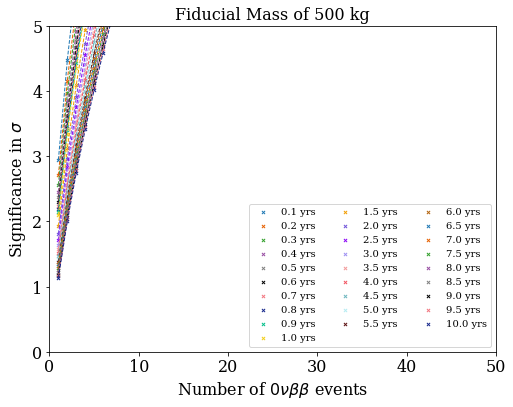

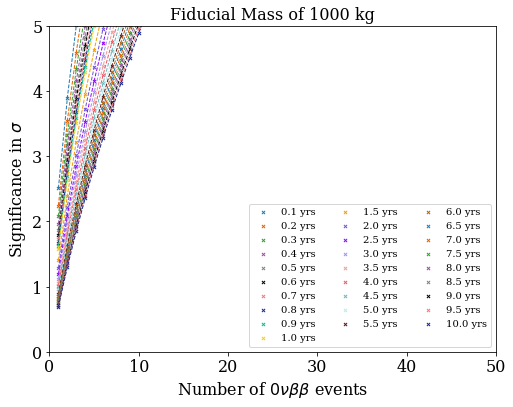

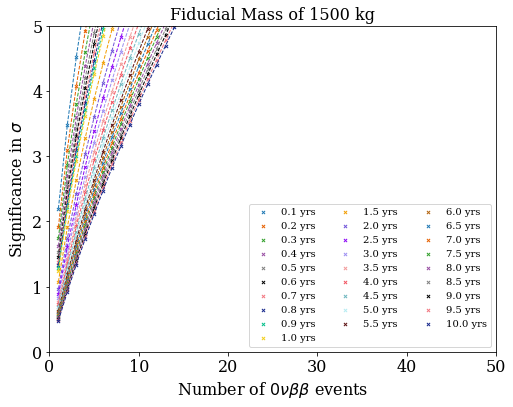

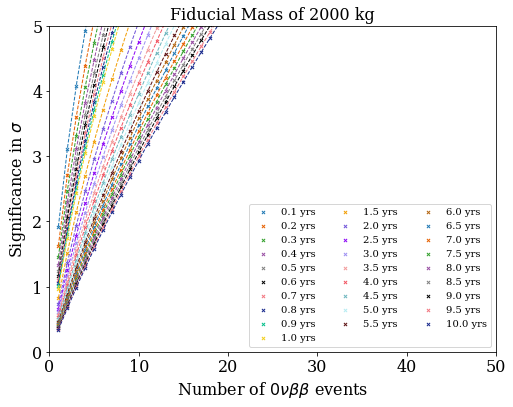

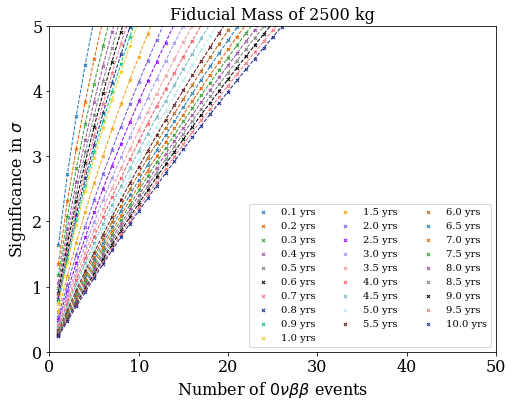

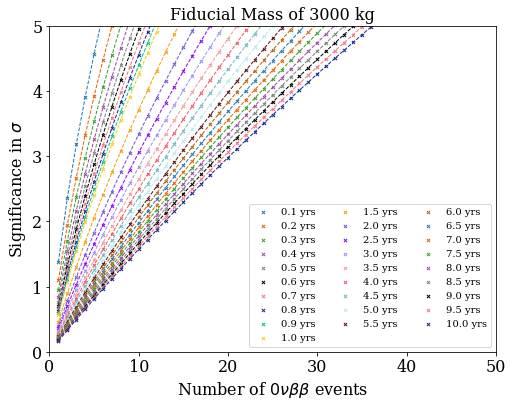

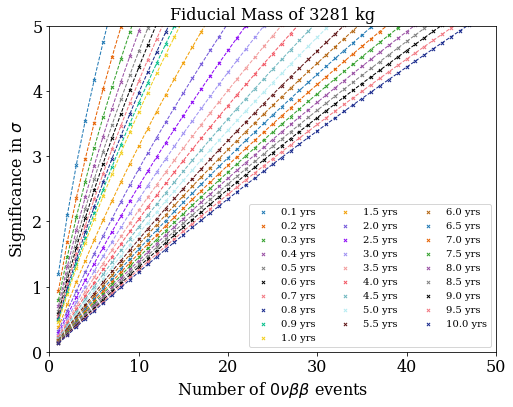

In [17]:
Halflife = {}

for ii,Mass in enumerate(XenonMass):  
    Halflife[Mass] = []
    
    plt.figure(figsize=(8,6))
    plt.xlabel(r'Number of $0\nu\beta\beta$ events')
    plt.ylabel(r'Significance in $\sigma$')
    for jj,Time in enumerate(Livetime): 
        plt.scatter(Signal[ii][jj]['Counts'], Signal[ii][jj]['SignificanceWithBackground'], label='%.1f yrs' % Time, color = colors[jj], s=10, marker='x')
        LinearCut = np.where(np.array(Signal[ii][jj]['SignificanceWithBackground'])<100)[0][-1]
        XInterp = np.linspace(np.min(Signal[ii][jj]['Counts']),Signal[ii][jj]['Counts'][LinearCut],1000)

        Interpolation = np.interp(XInterp, Signal[ii][jj]['Counts'][:LinearCut+1], Signal[ii][jj]['SignificanceWithBackground'][:LinearCut+1])
        Diff = np.abs(Interpolation - 3.0)
        Cut = np.where(Diff == np.min(Diff))[0][0]
        
#         print(ii,jj,XInterp[Cut], Interpolation[Cut], GetHalflifeFromSignalCount(XInterp[Cut], Bb0nEfficiency, GetNumberOfXeAtoms(Mass), Time))

        plt.plot(XInterp,Interpolation, ls='--', color=colors[jj])
        
        Halflife[Mass].append(GetHalflifeFromSignalCount(XInterp[Cut], 0.50974, GetNumberOfXeAtoms(Mass), Time))
        
    plt.xlim(0,50.0)
    plt.ylim(0,5)
    plt.title('Fiducial Mass of %d kg' % Mass, fontsize=16)
    plt.legend(loc='lower right', fontsize=10, ncol=3)
    plt.savefig('significance_%dkg_%dyrs.pdf' % (Mass,Time), bbox_inches='tight')

In [18]:
import pandas as pd
data = pd.read_csv('2017_discovery_potential.csv',  header=None, usecols=[0,1])

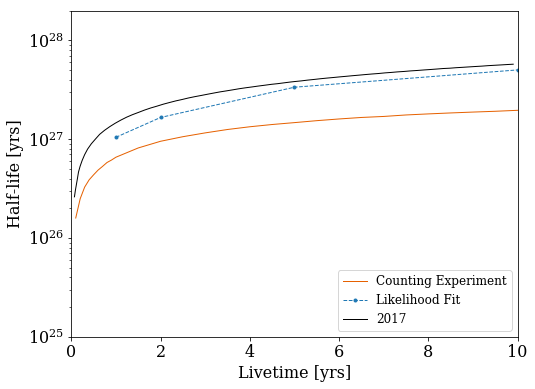

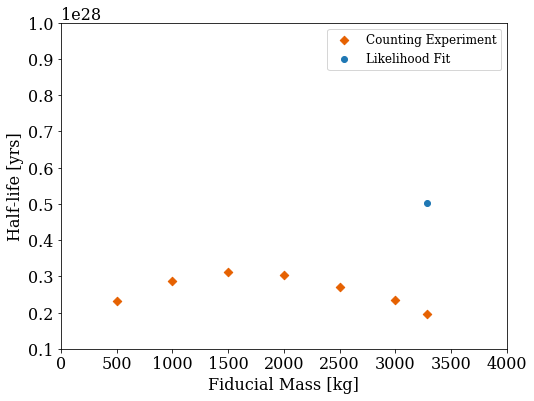

In [19]:
plt.figure(figsize=(8,6))
plt.xlabel(r'Livetime [yrs]')
plt.ylabel(r'Half-life [yrs]')
for ii,key in enumerate(Halflife.keys()):
    if key == 3281.0:
        plt.plot(Livetime,Halflife[key], label='Counting Experiment', color=colors[1])
#     plt.plot(Livetime,Halflife[key], label='%d kg' % key, color=colors[ii])
#         plt.scatter(Livetime,Halflife[key], label='')

plt.xlim(0,10)
plt.ylim(1E25, 2E28)
plt.yscale('log')
livetime = [1.0, 2.0, 5.0,10.0]
discovery = [1.0452531540965649e+27, 1.6586825705804897e+27, 3.3579337802678305e+27, 5.026e+27]
# plt.scatter(livetime, discovery, label='Likelihood Fit', color='k', marker='.')
plt.plot(livetime, discovery, label='Likelihood Fit', color=colors[0], marker='.', ls='--')
plt.plot(data[0], data[1], label='2017', color='k', ls='-')

plt.legend(loc='lower right')
plt.savefig('halflife_vs_livetime.pdf', bbox_inches='tight')

plt.figure(figsize=(8,6))
plt.xlabel(r'Fiducial Mass [kg]')
plt.ylabel(r'Half-life [yrs]')
plt.xlim(0,4000)
plt.ylim(1E27, 10E27)
for ii,key in enumerate(Halflife.keys()):
    if ii == 0:
        plt.scatter(float(key), Halflife[key][-1], color=colors[1], marker='D', label='Counting Experiment')
    else:
        plt.scatter(float(key), Halflife[key][-1], color=colors[1], marker='D')
plt.scatter(3281.0, discovery[-1], label='Likelihood Fit', color=colors[0])
plt.legend(loc='upper right')



plt.savefig('halflife_vs_mass.pdf', bbox_inches='tight')